In [1]:
import os
import sys
import numpy as np
import pandas as pd
import scipy
import scipy.special
import math
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import progressbar

import keras
import keras.preprocessing.image
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

if '..' not in sys.path:
    sys.path.append('..')
import src
import src.vector_vortex_beams as VVB
import src.utils as utils
from src.utils import abs2

%matplotlib inline
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


# Train and test CNNs on simulated VVBs

In [540]:
classifier = Sequential()
classifier = Sequential()
classifier.add(Conv2D(16, (3, 3), input_shape=(128, 128, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size = (10, 10)))
classifier.add(Conv2D(16, (3, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(5, 5)))
classifier.add(Flatten())
classifier.add(Dense(units=32, activation='relu'))
classifier.add(Dense(units=15, activation='softmax'))

# Compile CNN for classification problem
classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1/255, zoom_range=[0.8, 1.2])
training_set = train_datagen.flow_from_directory(
    '../data/simulated 15 classes/train',
    target_size=(128, 128), batch_size=32, class_mode='categorical'
)

test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
test_set = test_datagen.flow_from_directory(
    '../data/simulated 15 classes/test',
    target_size=(128, 128), batch_size=32, class_mode='categorical'
)
h = classifier.fit_generator(
    training_set, steps_per_epoch=200,  # 8000
    epochs=3, validation_data=test_set, validation_steps=100  # 2000 steps
)

# classifier.save('../saved_CNN_models/2convs_10and5pools_32dense.h5')

Found 6056 images belonging to 15 classes.
Found 4215 images belonging to 15 classes.
Epoch 1/3
200/200 [==============================] - 133s 665ms/step - loss: 1.9900 - acc: 0.3739 - val_loss: 0.7905 - val_acc: 0.8478
Epoch 2/3
200/200 [==============================] - 132s 660ms/step - loss: 0.4406 - acc: 0.9158 - val_loss: 0.1621 - val_acc: 0.9987
Epoch 3/3
200/200 [==============================] - 131s 653ms/step - loss: 0.1548 - acc: 0.9780 - val_loss: 0.0639 - val_acc: 0.9994


Test trained CNN feeding it directly with a manually resized image from the dataset:

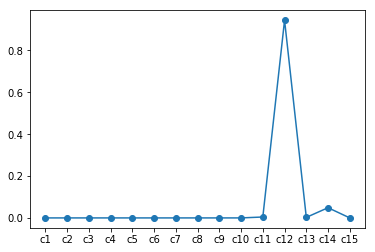

In [7]:
def _():
    classifier = keras.models.load_model('../saved_CNN_models/2convs_10and5pools_32dense.h5')
    image_path = '../data/simulated 15 classes/train/c12/c12_100.png'
    with PIL.Image.open(image_path) as image:
        image = np.asarray(image.resize(size=(128, 128))) / 255
        ans = classifier.predict(np.asarray([image]))
        plt.plot(['c{}'.format(idx + 1) for idx in range(15)], ans[0], 'o-')
_()

## Truth table

Manually load all images and test the trained model on them..
Test a trained model on the test set, and print truth table and (some of the) mispredicted images. Note how the mispredicted images are all images that were 

Found 4200 images belonging to 15 classes.


100%|██████████| 4200/4200 [00:44<00:00, 94.13it/s]


Found 4200 images belonging to 15 classes.


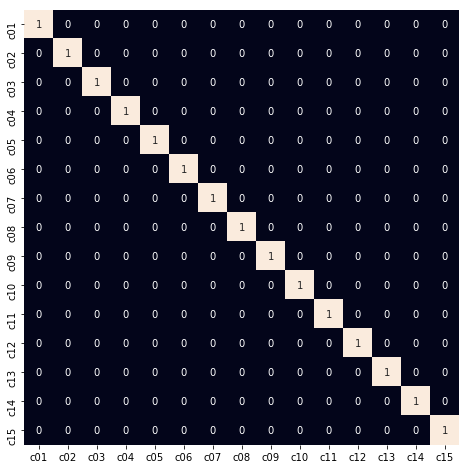

In [19]:
def _():
    # load trained model
    classifier = keras.models.load_model('../saved_CNN_models/2convs_10and5pools_32dense.h5')
    dataset_path = '../data/simulated 15 classes/test'
    all_images, true_labels = utils.load_images_and_labels_from_dir(dataset_path)
    classes_to_indices_dict = utils.serialize_class_directories(dataset_path)
    predictions = classifier.predict_classes(all_images)
    utils.print_truth_table(true_labels, predictions, classes_to_indices_dict)
_()

# Train on simulated, test on experimental VVBs

We try here to train a CNN on exclusively simulated images (noisy or noiseless), and have it generalise to experimental ones. Despite applying heavy preprocessing of simulated images, we don't get accuracies on experimental images much better than ~0.25. Heavy preprocessing helps, but not enough.

## Show preprocessed images used for the training

Found 7500 images belonging to 15 classes.


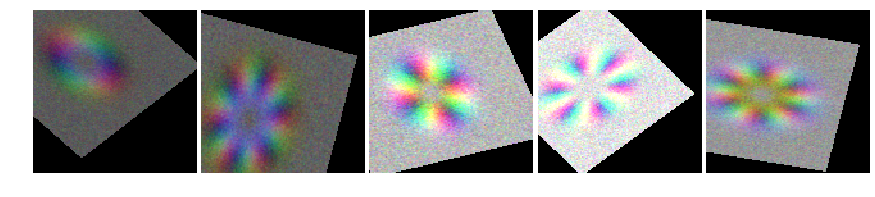

In [1278]:
utils.imshow_row(
    ImageDataGenerator(
        shear_range=0.4, rotation_range=90, rescale=1/255,
        zoom_range=[0.7, 1.3], brightness_range=[0.5, 2],
        width_shift_range=0.3, height_shift_range=0.3, fill_mode='constant'
    ).flow_from_directory(simulated15classesnoisy_dataset_dir, target_size=(128, 128)).next()[0][:5],
    plt_opts=dict(figsize=(15, 3))
);

## Build and train model

In [ ]:
classifier = Sequential()
classifier.add(Conv2D(32, (3, 3), input_shape=(128, 128, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size = (4, 4)))
classifier.add(Conv2D(32, (3, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(3, 3)))
classifier.add(Conv2D(32, (3, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))
classifier.add(Flatten())
classifier.add(Dense(units=64, activation='relu'))
classifier.add(Dense(units=15, activation='softmax'))
classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

simulated15classesnoisy_dataset_dir = './data/simulated15classes_noise0.1'
exp15classes_dataset_dir = './data/experimental/15classes'

from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    shear_range=0.4, rotation_range=90, rescale=1/255,
    zoom_range=[0.7, 1.3], brightness_range=[0.5, 2],
    width_shift_range=0.3, height_shift_range=0.3, fill_mode='constant')
test_datagen = ImageDataGenerator(rescale=1/255)

dataset_sim15classesnoisy = train_datagen.flow_from_directory(
    simulated15classesnoisy_dataset_dir,
    target_size=(128, 128), batch_size=32, class_mode='categorical')
dataset_exp15classes = test_datagen.flow_from_directory(
    exp15classes_dataset_dir,
    target_size=(128, 128), batch_size=32, class_mode='categorical')

h = classifier.fit_generator(
    dataset_sim15classesnoisy, validation_data=dataset_exp15classes,
    steps_per_epoch=200, epochs=200)
# classifier.save('./saved_CNN_models/3convs_432pools_64dense_sim2expCrapAcc.h5')

To directly load the result of training this net use:

In [1289]:
# classifier = keras.models.load_model('./saved_CNN_models/3convs_432pools_64dense_sim2expCrapAcc.h5')

Evaluate trained net

In [1282]:
print('Final accuracy on experimental dataset:')
classifier.evaluate_generator(ImageDataGenerator(rescale=1/255).flow_from_directory(
        directory='./data/experimental/15classes', target_size=(128, 128)
))[1]

Final accuracy on experimental dataset:
Found 1971 images belonging to 15 classes.


0.25570776256463784

Plot histories of training and validation accuracies:

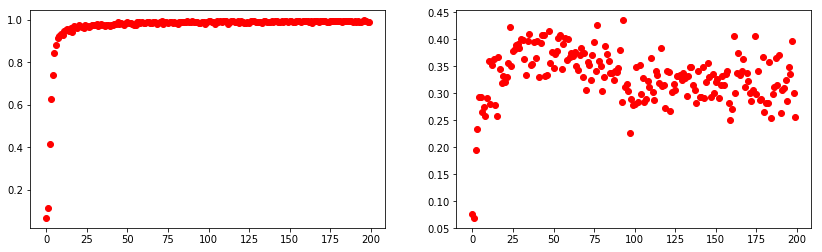

In [1269]:
utils.plot_row(
    data=[np.asarray(h.history['acc']),h.history['val_acc']],
    str_opts='ro', plt_opts=dict(figsize=(14, 4)));

## Truth table

Loaded the model. Loading images...
Found 1971 images belonging to 15 classes.


100%|██████████| 1968/1968 [00:23<00:00, 85.16it/s]


Found 1971 images belonging to 15 classes.


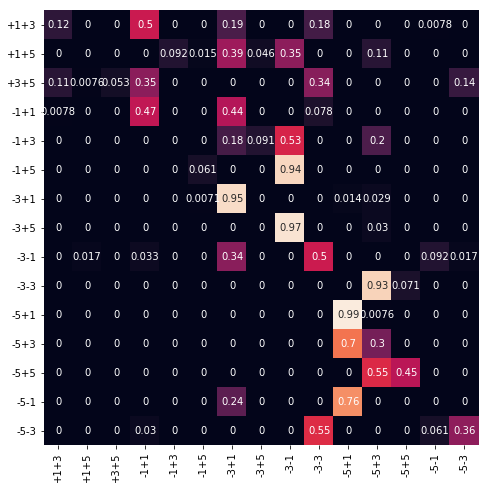

In [1291]:
def _():
    # load trained model
    classifier = keras.models.load_model('./saved_CNN_models/3convs_432pools_64dense_sim2expCrapAcc.h5')
    print('Loaded the model. Loading images...')
    dataset_path = './data/experimental/15classes'
    all_images, true_labels = utils.load_images_and_labels_from_dir(dataset_path)
    classes_to_indices_dict = utils.serialize_class_directories(dataset_path)
    predictions = classifier.predict_classes(all_images)
    utils.print_truth_table(true_labels, predictions, classes_to_indices_dict)
_()

# Train and test on experimental VVBs

In [637]:
!ls ./data/experimental

15classes	 26classes	  bloch_sphere_26classes_withAngles
15classes_split  26classes_split  other_distinct_classes


## Generate dataset

We need to split the experimental dataset to see how many experimental images are needed to accurately classify the rest (this takes some time, and requires some free memory).

In [ ]:
x_train, y_train, x_test, y_test = utils.split_dataset_into_train_and_test(
    original_path='../data/experimental/15classes',
    dim_train_set=20
)
# save_data_into_files(
#     x_test, y_test,
#     classes_dict=utils.serialize_class_directories('./data/experimental/15classes'),
#     new_path='./data/experimental/15classes_split_20trainperclass/test'
# )

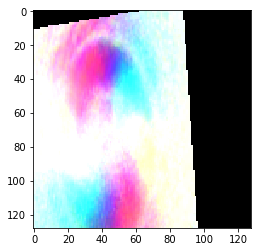

In [1206]:
foo = ImageDataGenerator(
        shear_range=0.2, rotation_range=90, zoom_range=[0.7, 1.3],
        brightness_range=[0.5, 2], fill_mode='constant',
        width_shift_range=0.3, height_shift_range=0.3, rescale=1/255
    ).flow(x=x_train, y=y_train, batch_size=32).next()[0][0]
plt.imshow(foo);

## Build and train model

In [ ]:
classifier = Sequential()
classifier.add(Conv2D(32, (3, 3), input_shape=(128, 128, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size = (4, 4)))
classifier.add(Conv2D(32, (3, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(3, 3)))
classifier.add(Conv2D(32, (3, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))
classifier.add(Flatten())
classifier.add(Dense(units=64, activation='relu'))
classifier.add(Dense(units=15, activation='softmax'))
classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

h = classifier.fit_generator(
    ImageDataGenerator(
        shear_range=0.2, rotation_range=90, zoom_range=[0.7, 1.3],
        brightness_range=[0.5, 2], fill_mode='constant',
        width_shift_range=0.3, height_shift_range=0.3, rescale=1/255
    ).flow(x=x_train, y=y_train, batch_size=32),
    steps_per_epoch=200, epochs=100, validation_data=(x_test, y_test)
)
# classifier.save('./saved_CNN_models/3convs_432pools_64dense_exp2expGreatAcc.h5')

History of **in**accuracy on train and test sets (in log scale):

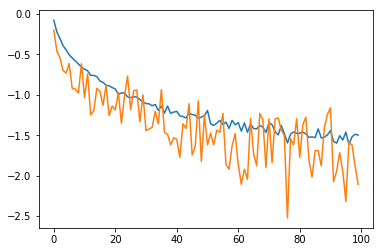

In [1184]:
plt.plot(np.log10(1 - np.asarray(h.history['acc'])))
plt.plot(np.log10(1 - np.asarray(h.history['val_acc'])));

## Evaluate trained model

Final accuracy on train set: 1

In [1187]:
classifier.evaluate(x=x_train, y=y_train)

300/300 [==============================] - 1s 2ms/step


[0.004852904556323665, 1.0]

Final accuracy on test set: ~0.992

In [1188]:
classifier.evaluate(x=x_test, y=y_test)

1668/1668 [==============================] - 4s 2ms/step


[0.023006330522504084, 0.9922062350119905]

Let's have a look at the misclassified images:

In [1189]:
print(np.argwhere(classifier.predict_classes(x=x_train) != np.argmax(y_train, axis=1)).flatten())
print(np.argwhere(classifier.predict_classes(x=x_test) != np.argmax(y_test, axis=1)).flatten())

[]
[ 143  190  269  576  805  819 1350 1428 1502 1536 1628 1639 1644]


Looking at misclassified images doesn't seem to reveal any obvious reason why the network failed on those:

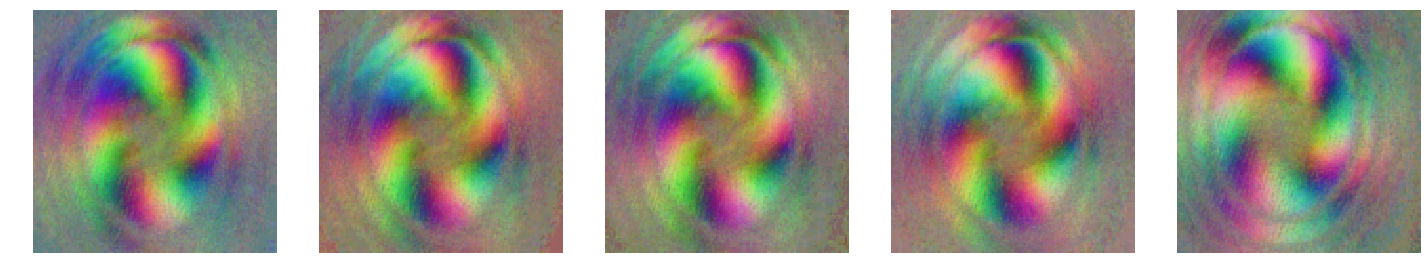

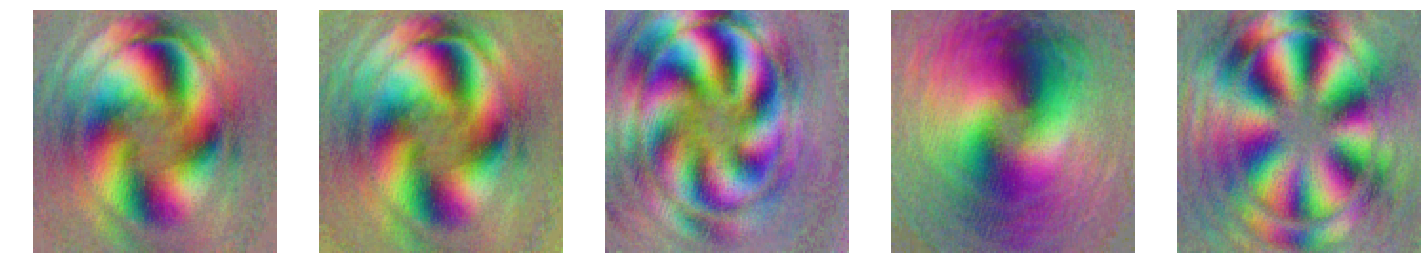

In [1197]:
_, axs = plt.subplots(1, 5, figsize=(20, 10))
[ax.imshow(img) for ax, img in zip(axs, x_test[140:145])];
[ax.axis('off') for ax in axs]; plt.tight_layout()

_, axs = plt.subplots(1, 5, figsize=(20, 10))
[ax.imshow(img) for ax, img in zip(axs, x_test[[143, 190, 269, 576, 805]])];
[ax.axis('off') for ax in axs]; plt.tight_layout()

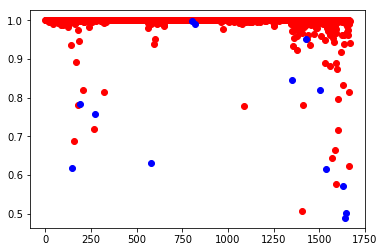

In [1195]:
def _():
    good_indices = np.argwhere(classifier.predict_classes(x_test) == np.argmax(y_test, axis=1)).flatten()
    bad_indices = np.argwhere(classifier.predict_classes(x_test) != np.argmax(y_test, axis=1)).flatten()
    _, ax = plt.subplots(1, 1)
    ax.plot(good_indices, np.max(classifier.predict(x_test[good_indices]), axis=1), 'ro')
    ax.plot(bad_indices, np.max(classifier.predict(x_test[bad_indices]), axis=1), 'bo')
_()

## Truth table

Found 1971 images belonging to 15 classes.


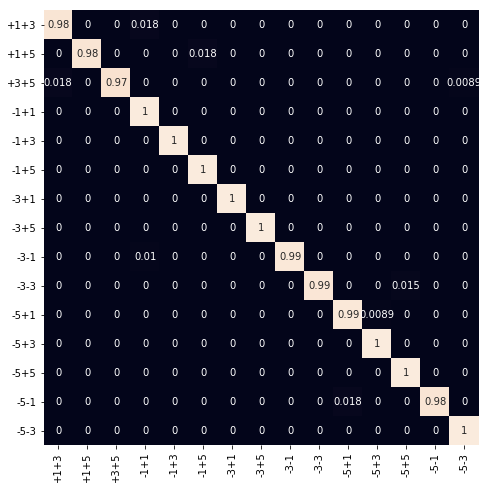

In [1196]:
utils.print_truth_table(np.argmax(y_test, axis=1), classifier.predict_classes(x_test),
                        utils.serialize_class_directories('../data/experimental/15classes'))